# Computing a 2D histogram using Histogram object
Here we use a 2d histogram to compute a series of 1d histograms in parallel from different channels.
The image generator simulates the counts measured by a series of Nc counting detectors.

The essential pieces for the call are:

```h = Histogram([Nh,0,mu0*3],[Nc,0,Nc+1])```

and 

```h.fill(channelvals,channelinds)```

In [1]:
%%latex
The counts per channel should follow a Poisson probability distribution:
    \begin{eqnarray*}
    P(k) & = & e^{-\lambda} \frac{\lambda^k}{k!}
    \end{eqnarray*}
    The $\lambda$ parameter is also allowed to fluctuate on some uniform distribution:
    \begin{eqnarray*}
    P_\lambda(\lambda) & = & \frac{1}{2 \Delta} \Theta(|1- \frac{\mu-\mu_0}{\Delta}|)\\
    \Theta(x) & = & \left \{ \begin{array}{c c} 1 & |X| < 0\\
                            0 & |X|>0
                            \end{array}\right.
    \end{eqnarray*}

<IPython.core.display.Latex object>

In [2]:
# Import libraries
import time as ttime
import numpy as np
from matplotlib import pyplot as plt

%matplotlib notebook

#The Histogram object
from skbeam.core.accumulators.histogram import Histogram

In [3]:
# Define intial parameters and image generator

# numer of repeats
N = 1000
# number of channelvals
Nc = 100
# avg intensity
mu0 = 1e3 
# percentage deviation (from uniform distribution of counts)
dev = 0
# Number of bins for histogram
Nh = 1000#3*mu0
# the channel indices to create a one to one correspondence between
# channels and bins (i.e. no binning desired in this dimension)
channelinds = np.arange(Nc).astype(float)

# line intensity generator
def gen(N, Nc, mu0, dev):
    ''' Generate a sequence of N images with Nc channels.
    The values are returned as counts with Poisson probability distribution
    that depends on mu0, which is a stochastic parameter that varies uniformly per channel 
    from mu0*(1-dev) to mu0*(1+dev)
    '''
    channelvals = np.ones(Nc)
    # flatfield 
    flatfield = 1+(np.random.random(Nc)-.5)*dev
    for i in range(N):
        yield np.random.poisson(mu0*channelvals*flatfield).astype(float)

<IPython.core.display.Javascript object>


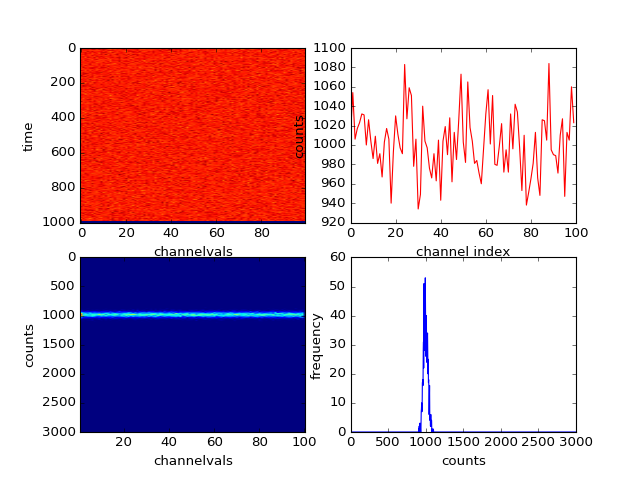

In [4]:
# Initialize histogram, give tuples of [Nbins, Low, High] for each dimension
h = Histogram([Nh,0,mu0*3],[Nc,0,Nc+1])

# This is meant to store the waterfall plot for demonstration purposes
img = np.zeros((N, Nc))

# the extent of the histogram image
extent=[h.centers[1][0],h.centers[1][-1],h.centers[0][-1],h.centers[0][0]]

# set up the figure
fig,((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2)

In [5]:
# loop over images from generator and accumulate into the histogram
for i, channelvals in enumerate(gen(N, Nc, mu0, dev)):
    # fill histogram
    h.fill(channelvals,channelinds)
    # store data in a waterfall plot
    img[i] = channelvals

    # plot results, but only intermittently, so the updating does not 
    # take a long time
    if i % 10 == 0:

        # the waterfall plot
        ax0.cla()
        ax0.imshow(img)
        ax0.set_aspect('auto')
        ax0.set_xlabel("channelvals")
        ax0.set_ylabel("time")

        # The instantaneous counts 
        ax1.cla()    
        ax1.plot(channelvals,'r')
        ax1.set_xlabel("channel index")
        ax1.set_ylabel("counts")

        # the histogram
        ax2.cla()
        ax2.imshow(h.values,extent=extent)
        ax2.set_aspect('auto')
        ax2.set_ylabel("counts")
        ax2.set_xlabel("channelvals")

        # A cross section of the 2D histogram array
        ax3.cla()    
        ax3.plot(h.centers[0],h.values[:,10])
        ax3.set_xlabel("counts")
        ax3.set_ylabel("frequency")

        fig.canvas.draw()
        # needed for plotting to update properly
        ttime.sleep(.01)